<a href="https://colab.research.google.com/github/Reptilefury/coursera-machine-learning/blob/main/Doctors_Handwriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq opendatasets

In [2]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/landlord/handwriting-recognition")

Skipping, found downloaded files in "./handwriting-recognition" (use force=True to force download)


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 #Python wrapper for open cv
from keras import backend as k

In [5]:
train = pd.read_csv("/content/handwriting-recognition/written_name_train_v2.csv")

In [6]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [7]:
validation = pd.read_csv("/content/handwriting-recognition/written_name_validation_v2.csv")

In [8]:
test = pd.read_csv("/content/handwriting-recognition/written_name_test_v2.csv")

In [9]:
test.head()

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN


In [10]:
validation.head()

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP


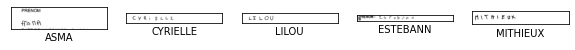

In [11]:
#Visualize the dataset before passing it into a computation graph
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  image_dir = "/content/handwriting-recognition/train_v2/train/" + train.loc[i,"FILENAME"]
  image = cv2.imread(image_dir,cv2.IMREAD_GRAYSCALE)
  plt.imshow(image,cmap="gray")
  plt.xlabel(train.loc[i,"IDENTITY"])
  plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [12]:
train.dropna(axis=0,inplace=True)
validation.dropna(axis=0,inplace=True)

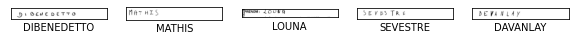

In [13]:
#Lets visualise the validation data 
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i +1)
  plt.xticks([])
  plt.yticks([])
  image_dir = "/content/handwriting-recognition/validation_v2/validation/" + validation.loc[i, "FILENAME"]
  image  = cv2.imread(image_dir,cv2.IMREAD_GRAYSCALE)
  plt.imshow(image,cmap="gray")
  plt.xlabel(validation.loc[i,"IDENTITY"])
  plt.subplots_adjust(wspace = 0.2, hspace = -0.8)

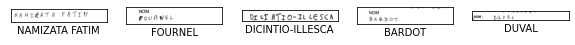

In [14]:
#Lets visualise the test set before forging ahead
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5, i + 1)
  plt.xticks([])
  plt.yticks([])
  image_dir = "/content/handwriting-recognition/test_v2/test/" + test.loc[i, 'FILENAME']
  image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
  plt.imshow(image,cmap = "gray")
  plt.xlabel(test.loc[i,"IDENTITY"])
  plt.subplots_adjust(wspace=0.2,hspace=-0.8)

In [15]:
#Unreadable data in the dataset
unreadable =  train[train["IDENTITY"]=="UNREADABLE"]

In [16]:
unreadable.reset_index( inplace = True ,drop = True)

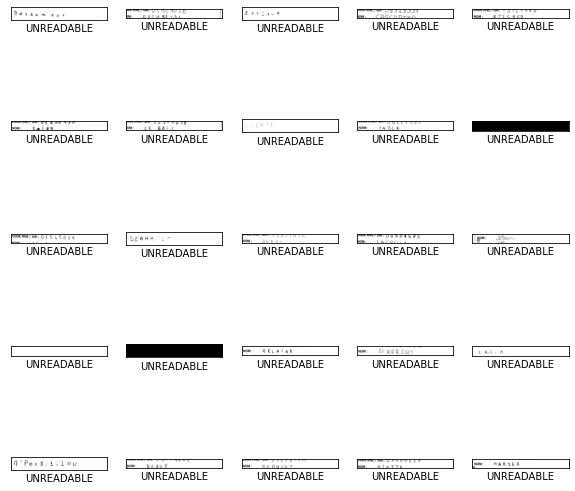

In [17]:
#Iterate through the  dataset and visualise every item in a certain range 
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i + 1)
  plt.xticks([])
  plt.yticks([])
  image_dir = "/content/handwriting-recognition/train_v2/train/" + unreadable.loc[i, "FILENAME"]
  image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
  plt.imshow(image, cmap="gray")
  plt.xlabel(unreadable.loc[i,"IDENTITY"])

In [24]:
#We exclude the unreadable data from the dataset
train = train[train["IDENTITY"] != "UNREADABLE"]

In [19]:
validation = validation[validation["IDENTITY"] != "UNREADABLE"]

In [28]:
train.reset_index(inplace=True,drop = True)
validation.reset_index(inplace = True, drop = True)

In [29]:
def preprocess(img):
  (h,w) = img.shape
  final_img = np.ones([64,256]) * 255
  if w>256:
    img = img[:,:256]
  if h>64:
    img = img[:64:, :]
  final_img[:h,:w] = img
  return cv2.rotate(final_img,cv2.ROTATE_90_CLOCKWISE)

In [30]:
train_size = 30000 
valid_size = 3000

In [31]:
train_x = [] #Create an empty list for the training data 

In [37]:
for i in range(train_size):
  image_dir = "/content/handwriting-recognition/train_v2/train/" + train.loc[i,"FILENAME"] #access each image in the filepath
  image = cv2.imread(image_dir,cv2.IMREAD_GRAYSCALE) #read the image
  image = preprocess(image) #preprocess the image  
  image =  image/255. #turn the image into floating point numbers between 0 and 1 
  train_x.append(image)

In [51]:
#Create an empty array that will store all the preprocessed images from the validation set
valid_x = []
#Preprocess the validation data 
for i in range(valid_size):
  image_dir = "/content/handwriting-recognition/validation_v2/validation/" + validation.loc[i, "FILENAME"]
  image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE) #Read the image 
  image = preprocess(image) #Preprocess the image  
  image = image/255. #Turn the image into floating point numbers in between 0 and 1 
  valid_x.append(image)

In [59]:
#We flatten the images/reshape the images into a one dimensional array/vector
train_x = np.array(train_x).reshape(-1,256,64,1) #We reshape the training images into a one dimensional array  i.e a vector 
valid_x = np.array(valid_x).reshape(-1,256,64,1) #We reshape the validation images into a one dimensional array i.e a vector

In [60]:
 for i in range(valid_size):
  image_dir = "/content/handwriting-recognition/validation_v2/validation/" + validation.loc[i,"FILENAME"]

In [61]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "

In [68]:
#We create a function that turns alphabets into numbers. takes in an input as string and turns them into numbers
def al_to_numbers(str):
  numlist =[] #An empty list which we'll add every alphabet from the input string 
  for a in str: #we iterate the input string
    num = alphabets.find(a) #We find the index of the char from the alphabetic order
    numlist.append(num) #we add the index into the empty list we created earlier
  return np.array(numlist) #We return the empty list in form of an array

In [70]:
def num_to_al(numlist):
  str = '' #create an empty string
  for num in numlist: #Iterate through the empty string
    if num == -1: #Check if the number in the list is equal to negative 1 
      break #if so break  
    else: #Else we add the value of the index into the empty string
      str += alphabets[num]
  return str #We return the string

In [72]:
#Let's test the alphabets to numbers
al_to_numbers("HELLO")

array([ 7,  4, 11, 11, 14])

In [78]:
hello_list = np.array([7,4,11,11,14]) #pass a list of numbers into a numpy array 

In [79]:
#We can now turn numbers back to alphabets
num_to_al(hello_list)

'HELLO'

In [81]:
#Define he max string length
max_str_len = 24
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64

In [86]:
train_y = np.ones([train_size, max_str_len]) * -1 #size of data in the dataset and the maximum length
train_label_len = np.zeros([train_size,1])
train_input_len = np.ones([train_size,1]) * (num_of_timestamps * 2)

In [90]:
for i in range(train_size):
  train_label_len[i] = len(train.loc[i, 'IDENTITY'])
  train_y[i,0:len(train.loc[i,'IDENTITY'])] = al_to_numbers(train.loc[i,'IDENTITY'])

In [93]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size,1])
valid_input_len = np.ones([valid_size,1]) * (num_of_timestamps - 2)